In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_probability as tfp
import sys
sys.path.append('../')

from utility.mnist_data import adversarial_data
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from keras.datasets import mnist
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.python.keras import backend
from tensorflow.keras.models import Model
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
import mediapy as media
from extra_keras_datasets import emnist
import pandas as pd
from scipy.stats import ttest_ind,kstest

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


In [2]:
# Building out MINST dataset
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

In [8]:
import sys
sys.path.append('../')

from utility.mnist_data.adversarial_data import MNIST_EMNIST,compute_dropout_uncertainty

data=MNIST_EMNIST()


INFO:root:Loading dataset = emnist


# Setting up the data: training with numbers, attacking with letters



In [35]:
# vanilla data
trainers,adversarials=data.get_taste_test()
print('Training Data')

media.show_images(trainers,columns=10,  border=True, height=100,cmap='flare')
print('Adversarial Data')
media.show_images(adversarials,columns=10,  border=True, height=100,cmap='flare')


Training Data


,,,,,,,,,


Adversarial Data


,,,,,,,,,


/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


AttributeError: 'AxesSubplot' object has no attribute 'set_titile'

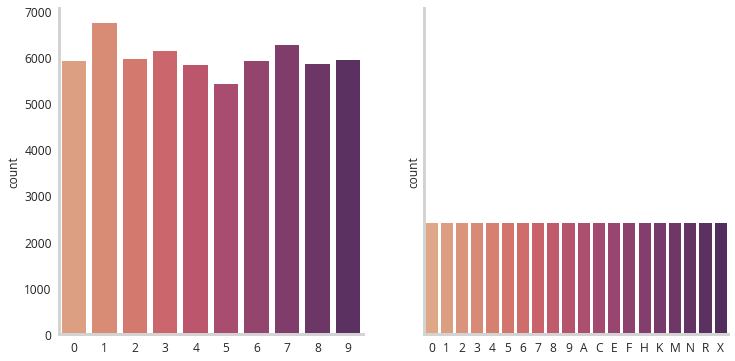

In [330]:
# data counts
fig,ax=plt.subplots(1,2,figsize=(12,6),sharey=True)

sns.countplot(data.train_keys,palette='flare',ax=ax[0])
# ax[1].set_xticklabels([0,1,2,3,4,5,6,7,8,9])

sns.countplot(data.holdout_training_keys,palette='flare',ax=ax[1])
ax[1].set_xticklabels([0,1,2,3,4,5,6,7,8,9,'A','C','E','F','H','K','M','N','R','X'])

ax[0].set_title('Training MNIST data')
ax[1].set_title('Adversarial Data')

/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


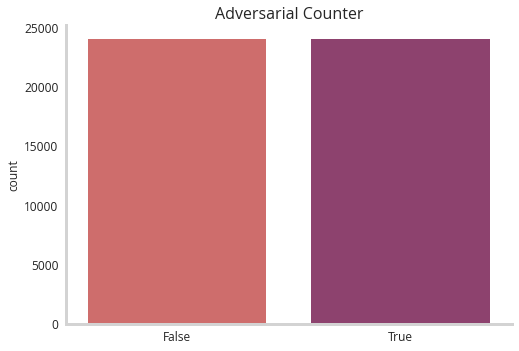

In [321]:
fig,ax=plt.subplots()
sns.countplot(data.adversarial_training_labels,palette='flare',ax=ax)
ax.set_title('Adversarial Counter')
fig.savefig('figures/adv_count.png',bbox_inches='tight',dpi=300)


# Training Model and Testing Performance

# Why you need dropout

Lets compare our shuffling and resampling of dropout for two charecters : the number 3 and the letter N. The model will be trained on digits (0-9), and expecting to see them. The letter N will be a suprise that it is not prepared for.

# Grabbing our "3" and "N" data

In [77]:
N_samples=data.X_adv_train[data.holdout_training_keys==23]
threes_samples=data.X_adv_train[data.holdout_training_keys==3]
eights_samples=data.X_adv_train[data.holdout_training_keys==8]
sevens_samples=data.X_adv_train[data.holdout_training_keys==7]

print('3s')
media.show_images(threes_samples[:10],columns=10,  border=True, height=100,cmap='flare')

print('Ns')
media.show_images(N_samples[:10],columns=10,  border=True, height=100,cmap='flare')



3s


,,,,,,,,,


Ns


,,,,,,,,,


# Comparing Models with and without Dropout

In [78]:
from utility.mnist_data.model_warehouse import *


Epoch 1/20
 257/1875 [===>..........................] - ETA: 4:02 - loss: 0.7772 - accuracy: 0.7457

KeyboardInterrupt: 

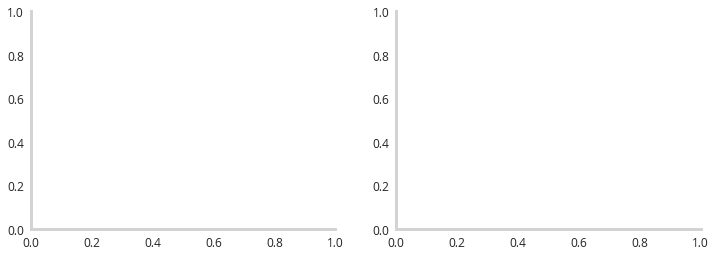

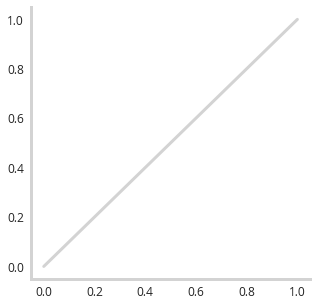

In [79]:
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True)
labels=['thicc','thicc_norm']
meta_metrics={}
palette='flare'
colors=sns.color_palette(palette, 2)

roc_fig,roc_ax=plt.subplots(figsize=(5,5))
roc_ax.plot([0,1],[0,1],color='#d3d3d3',linewidth=3)

for i,model_type in enumerate([thicc_CNN_dropout,thicc_CNN_dropout_with_norm]):
    metrics={}
    model = model_type()
    history = model.fit(data.X_train, data.y_train, epochs=20, batch_size=32, validation_data=(data.X_test, data.y_test), verbose=1)
    
    letter_dropout_means,letter_dropout_uncertainy=compute_dropout_uncertainty(model,N_samples)
    number_dropout_means,number_dropout_uncertainy=compute_dropout_uncertainty(model,sevens_samples)
    subset=pd.DataFrame({0:np.mean(number_dropout_uncertainy,axis=1),1:np.mean(letter_dropout_uncertainy,axis=1)}).melt()

    letter_values=np.mean(letter_dropout_uncertainy,axis=1)
    number_values=np.mean(number_dropout_uncertainy,axis=1)
    letter_mean=np.round(np.mean(letter_dropout_uncertainy),2)
    number_mean=np.round(np.mean(number_dropout_uncertainy),2)
    
    metrics['k_metric']=kstest(letter_values,number_values)[0]
    
    metrics['diff_means']=letter_mean-number_mean

    print(f'{labels[i]}, letter uq : {letter_mean}, number uq :{number_mean}')
    
    sns.regplot(x="value", y="variable", data=subset,
                     logistic=True,
                n_boot=500, y_jitter=.1,line_kws={"color": colors[-1]},scatter_kws={'alpha':0.05,"color": colors[0]},ax=ax[i])
    
    ax[i].set_title(labels[i])
    ax[i].set_xlabel('Uncertainty')
    ax[i].set_yticks([0,1])
    ax[i].set_yticklabels(['8','N'])
    
    
    ### computing logistic regression
    ground=subset['variable'].values
    clf = LogisticRegression(random_state=0).fit(subset['value'].values.reshape(-1,1), ground)
    predictions=clf.predict_proba(subset['value'].values.reshape(-1,1))[:,1]
    fpr, tpr, _ = roc_curve(ground, predictions)
    roc_auc = auc(fpr, tpr)
    metrics['AUC']=roc_auc
    meta_metrics[labels[i]]=metrics

    roc_ax.plot(fpr, tpr, 
         lw=3, label=f'{labels[i]} {np.round(roc_auc,2)}',color=colors[i])

roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title(f'ROC curve \n Distinguishing between 3 and N \n based on uncertainty' )
roc_ax.legend()
roc_fig.savefig('figures/thicc_gauntlet_ROC_8.png',dpi=300,bbox_inches='tight')

    
fig.savefig('figures/thicc_gauntlet_8.png',dpi=300,bbox_inches='tight')
    

In [ ]:
# Computing classifier for adversarial /non-adversarial

In [238]:
from sklearn.linear_model import LogisticRegression

In [247]:
clf = LogisticRegression(random_state=0).fit(subset['value'].values.reshape(-1,1), subset['variable'].values)

In [260]:

predictions=clf.predict_proba(subset['value'].values.reshape(-1,1))[:,1]
ground=subset['variable'].values

Text(0.5, 1.0, 'ROC curve (AUC = 0.84)')

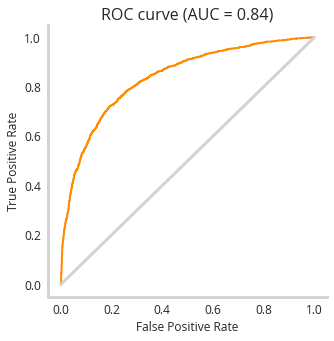

In [267]:

fpr, tpr, _ = roc_curve(ground, predictions)
roc_auc = auc(fpr, tpr)

lw = 2
# plt.figure()

fig,ax=plt.subplots(figsize=(5,5))

ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)

ax.plot([0,1],[0,1],color='#d3d3d3',linewidth=3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC curve (AUC = {np.round(roc_auc,2)})' )

# Running Complete Ecosystem

In [10]:
from utility.mnist_data.dropout_framework import DropoutMinstModel,KfoldMinstModel
from utility.mnist_data.model_warehouse import rich_CNN,thicc_CNN_dropout,basic_CNN,thicc_CNN_dropout_with_norm,double_thicc_CNN_dropout_with_norm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

INFO:root:Loading dataset = emnist
INFO:root:Starting mnist model training


Epoch 1/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3906 - accuracy: 0.8814 - val_loss: 0.0766 - val_accuracy: 0.9756
Epoch 2/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0912 - accuracy: 0.9723 - val_loss: 0.0472 - val_accuracy: 0.9846
Epoch 3/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0614 - accuracy: 0.9802 - val_loss: 0.0451 - val_accuracy: 0.9845
Epoch 4/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0466 - accuracy: 0.9847 - val_loss: 0.0443 - val_accuracy: 0.9854
Epoch 5/30
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0355 - accuracy: 0.9888 - val_loss: 0.0517 - val_accuracy: 0.9846
Epoch 6/30
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0289 - accuracy: 0.9898 - val_loss: 0.0471 - val_accuracy: 0.9861
Epoch 7/30
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0506 - val_ac

INFO:root:mnist model trained
INFO:root:Collecting UQ from dropout
100%|██████████| 100/100 [05:18<00:00,  3.19s/it]
INFO:root:Finished collecting UQ from dropout
100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


INFO:tensorflow:Assets written to: serialized_data/basic_30_100_shuffle/mnist.mdl/assets


INFO:tensorflow:Assets written to: serialized_data/basic_30_100_shuffle/mnist.mdl/assets


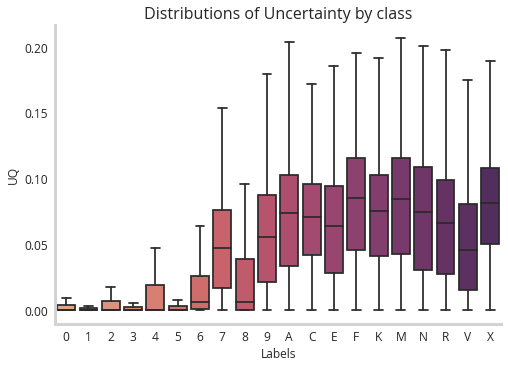

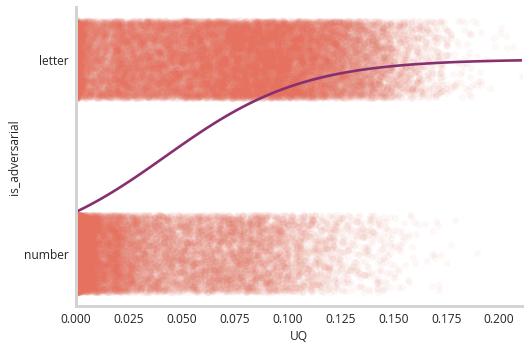

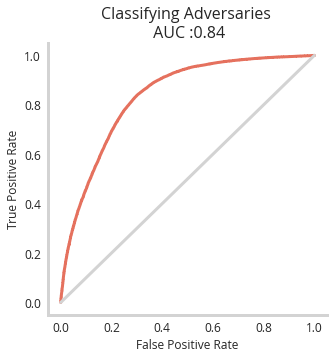

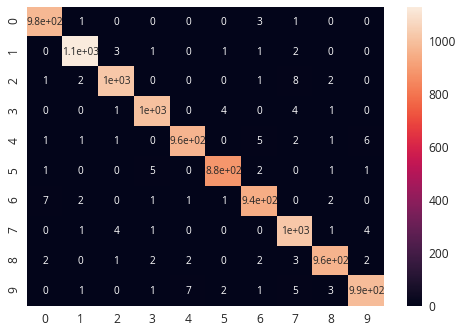

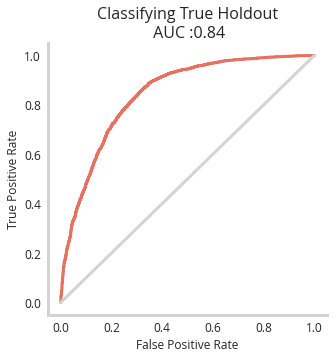

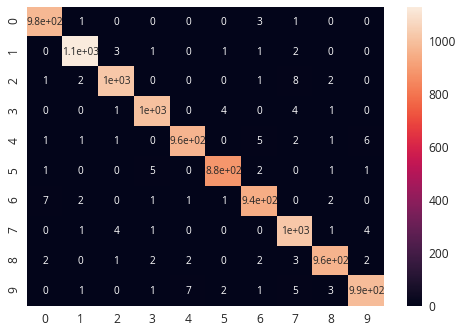

In [13]:
titles=['basic_30_100_shuffle']
for i, model in enumerate([basic_CNN]):

    complete_model=DropoutMinstModel(base_model=model,n_epochs=30,n_dropout_shuffles=100,title=titles[i])
    complete_model.train()
    complete_model.make_plots(f'figures/{titles[i]}')

In [67]:
complete_model.train()

INFO:root:Starting mnist model training


Epoch 1/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3889 - accuracy: 0.8796 - val_loss: 0.0701 - val_accuracy: 0.9783
Epoch 2/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0870 - accuracy: 0.9736 - val_loss: 0.0505 - val_accuracy: 0.9833
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0578 - accuracy: 0.9825 - val_loss: 0.0459 - val_accuracy: 0.9858
Epoch 4/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0413 - accuracy: 0.9864 - val_loss: 0.0454 - val_accuracy: 0.9847
Epoch 5/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0349 - accuracy: 0.9892 - val_loss: 0.0435 - val_accuracy: 0.9864
Epoch 6/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0259 - accuracy: 0.9909 - val_loss: 0.0405 - val_accuracy: 0.9880
Epoch 7/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.0454 - val_ac

INFO:root:mnist model trained
INFO:root:Collecting UQ from dropout
100%|██████████| 10/10 [00:37<00:00,  3.75s/it]
INFO:root:Finished collecting UQ from dropout
100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


# Comparing two solutions


In [72]:
# Loading Data
basic_uq=pd.read_csv('serialized_data/basic_cnn/uq_dataframe.csv')
thicc_uq=pd.read_csv('serialized_data/thicc_cnn/uq_dataframe.csv')

In [73]:
def generate_uncerainty_distributions(uq_dataframe):
    fig, ax = plt.subplots()
    sns.boxplot(x='Labels', y='UQ', data=uq_dataframe, palette='flare', showfliers=False)

    ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'A', 'C', 'E', 'F', 'K', 'M', 'N', 'R','V', 'X'])
    ax.set_title('Distributions of Uncertainty by class')
    return fig



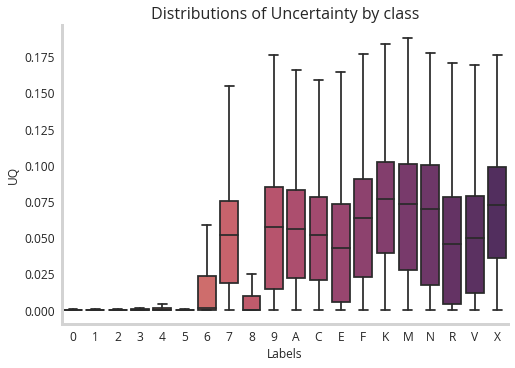

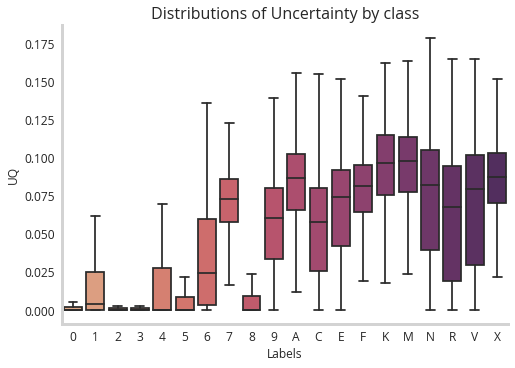

In [75]:
fig=generate_uncerainty_distributions(basic_uq)
fig=generate_uncerainty_distributions(thicc_uq)

In [34]:
complete_model.train()

INFO:root:mnist model trained :fold 1
INFO:root:mnist model trained :fold 2
INFO:root:mnist model trained :fold 3
INFO:root:mnist model trained :fold 4
INFO:root:mnist model trained :fold 5
INFO:root:Collecting UQ from dropout


AttributeError: 'list' object has no attribute 'mean'

In [35]:
complete_model._collect_kfold_uncertainty()

INFO:root:Collecting UQ from dropout
INFO:root:Finished collecting UQ from dropout


In [36]:
complete_model._train_dropout_uncertainty_model()


KeyError: 'mnist_confusion_matrix'

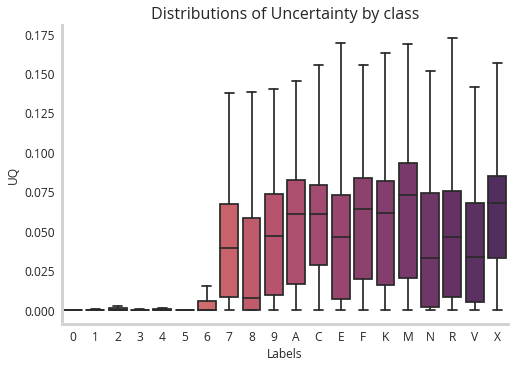

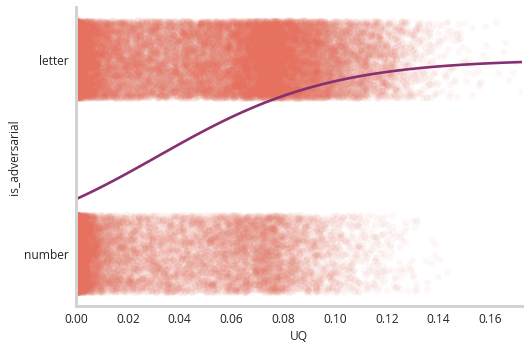

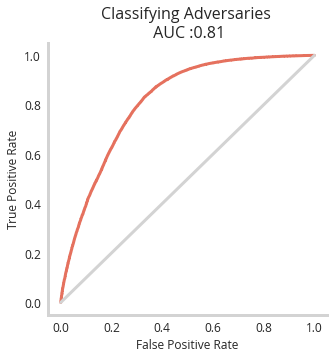

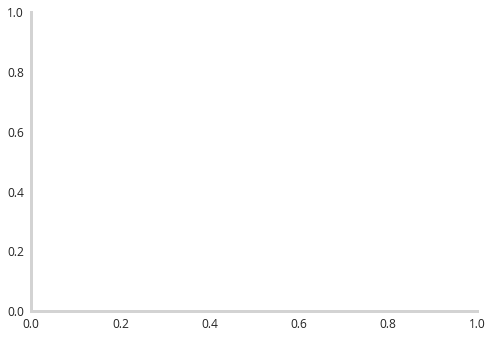

In [37]:
complete_model.make_plots(os.path.abspath('figures'))

In [6]:

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [8]:
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories



In [18]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)


In [24]:
#scores, histories = evaluate_model(trainX, trainY)
# train model
model = define_model()
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

In [58]:


partial_model = Model(model.inputs, model.layers[-1].output)
result = []
n_iter=10
for i in range(n_iter):
    result.append(partial_model(testX))

result = np.array(result)

prediction_mean = result.mean(axis=0)
prediction_std=result.std(axis=0)
        


In [65]:


prediction_mean = result.mean(axis=0)
prediction_std=result.std(axis=0)
        

In [67]:
prediction_std[0]

array([6.7762636e-21, 5.5511151e-17, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 6.9388939e-18], dtype=float32)

In [57]:
testX.shape

(10000, 28, 28, 1)

In [39]:
testX[0].shape

(28, 28, 1)

In [75]:
X, y= emnist.load_data()


INFO:root:Loading dataset = emnist


In [77]:
y

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],